# Pertussis Analysis: Serum Proteomics

Analysis of serum proteomics data (generated by Ferran) from the *Profiling of immune alterations in acellular and whole-cell vaccine-primed individuals after receiving Tdap booster vaccine* manuscript. This notebook was created using Python version 3.7.3.

## § 1: Setup
The following blocks will implement some optional Jupyter preferences, handle the imports needed for the analysis, define useful functions, and load the required data.

### § 1.1: Quality of Life Preferences (OPTIONAL)

In [1]:
# Jupyterthemes dark theme enabled. Revert to standard w/: jt -r
!jt -t chesterish

### § 1.2: Imports

In [2]:
import pandas as pd
import numpy as np
from scipy.spatial import distance as sdist
from scipy.cluster import hierarchy as sch
from matplotlib import pyplot as plt

from platform import python_version
print(python_version())

3.7.3


### § 1.3: Functions

In [3]:
### No functions currently defined ###

### § 1.4: Required Files

In [4]:
# Load the metadata
ptmetadata = pd.read_csv('Pertussis_data/pertussis_metadata.tsv',
                         sep='\t', index_col=3, converters={'subject':lambda s: str(s)})

In [5]:
# Load the serum proteomics data
serum_conc = pd.read_csv('Pertussis_data/Uniprot_results.csv', index_col=0)

## § 2: Analysis

### § 2.1: Filtering Proteins
We will take only those with an average coeffficient of variation greater than 0.1

In [6]:
# Take only samples were all the proteins are present 
# Some have no data Contact Ferran about the source Uniprot_results.csv file
have_all_prots = serum_conc.columns[-serum_conc.isna().any(axis=0)] 
mdata = ptmetadata.loc[have_all_prots]

# Create data frame with proteins as rows and subjects as columns
var = pd.DataFrame(index=serum_conc.index, columns=sorted(set(mdata.subject)))
for subject in var.columns:
    # data is exponentiated because Olink give us log2 scaled values
    subdata = np.exp2(serum_conc[mdata[mdata.subject==subject].index]) 
    cv = subdata.std(axis=1) / subdata.mean(axis=1)
    var.loc[cv.index, subject] = cv
    
# Averaging across the donors CV should be greater than 0.1    
variable = var[var.mean(axis=1).abs()>0.1].index
print("{:d} proteins left after filtering".format(variable.shape[0]))

conc_data = serum_conc.loc[variable]

209 proteins left after filtering


### § 2.2: Normalize the data to day 0

In [7]:
day0norm = conc_data[mdata.index].copy()
for subject in set(mdata['subject']):
    subject_samps = mdata[mdata.subject==subject].index
    day0samp = mdata[(mdata.subject==subject)&(mdata.visitN==1)].index
    assert len(day0samp)==1
    day0samp = day0samp[0]
    for smpl in subject_samps:
        day0norm[smpl] = conc_data[smpl] / conc_data[day0samp]
data = day0norm

# Also normalise to variance 1
data = data.divide(data.std(axis=1), axis=0)

### § 2.3: Actual Clustering

In [8]:
D = sdist.pdist(data.values, 'correlation')
Y = sch.linkage(D, method='average')


thr = 0.486 # this threashold was actually picked using kind of elbow criterion

clust = pd.DataFrame(index=data.index, columns=['cluster', 'genename', 'clusterN'])

fc = sch.fcluster(Y, thr*max(Y[:,2]), 'distance')

for clr, gid in zip(fc, data.index):
    clust.loc[gid, 'cluster'] = 'serumC'+str(clr)
    clust.loc[gid, 'clusterN'] = clr
    

clust.reset_index(inplace=True)
clust.set_index('UniProt', inplace=True)

### § 2.4: Plotting a Dendrogram

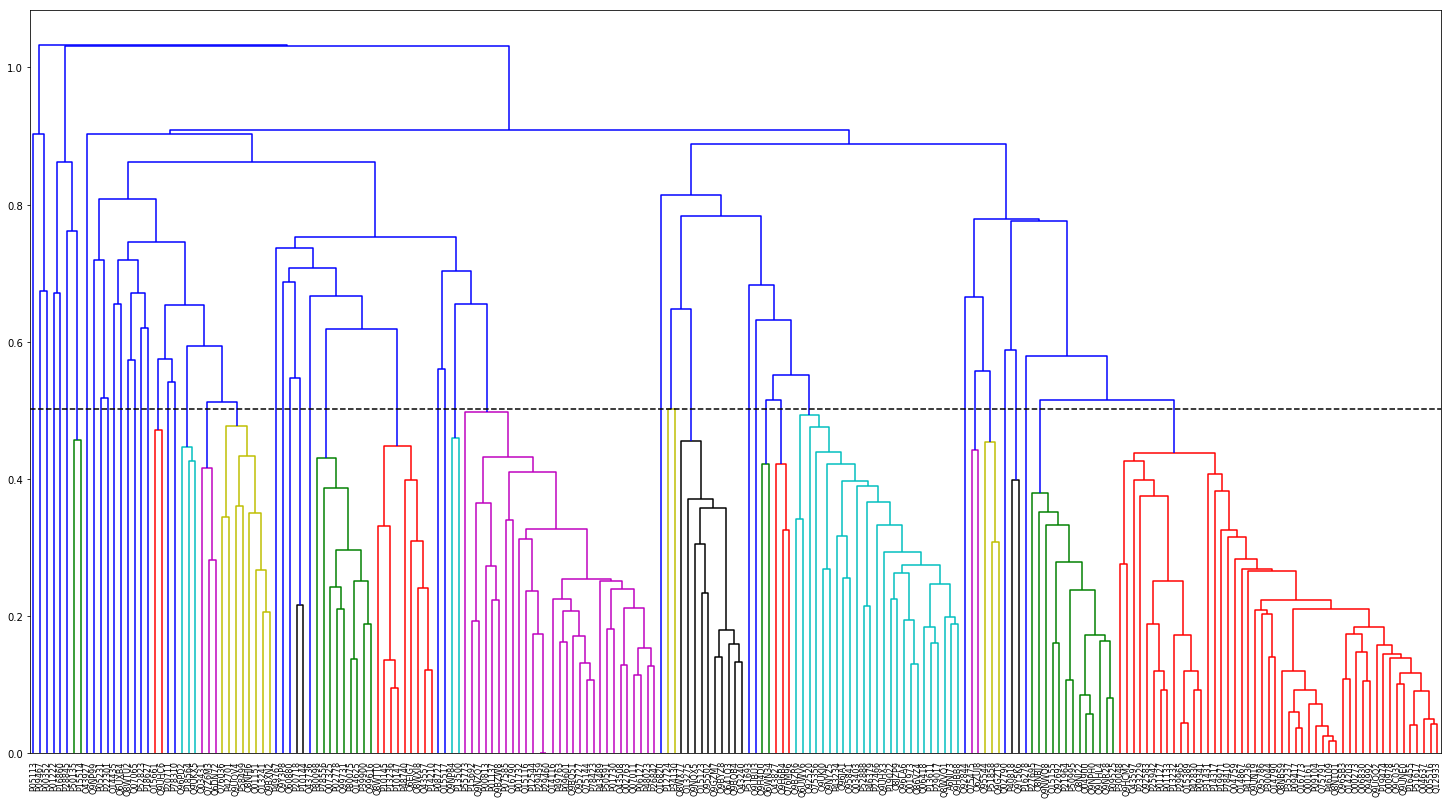

In [9]:
plt.clf()
fig = plt.gcf()
fig.set_size_inches([20.26, 11.28])
def llf(id):
    if id < len(data.index):
        return data.index[id]
    else:
        return ''

# llf is a leaf-labeling function
# the one below attemps to label with conventional gene names

# def llf(id):
#     hi = []
#     if id < len(data.index):
#         genename = uid2primname[data.index[id]]
#         if genename.startswith('CD40'):
#             pass
#         clst = clust.loc[data.index[id]]['clusterN']
#         #return str(clst)+'_'+genename
#         return genename
#     else:
#         return '*'

Z = sch.dendrogram(Y, leaf_label_func=llf, color_threshold=thr*max(Y[:,2]),
                   count_sort='ascending', leaf_font_size=8)

ax = plt.gca()
ax.hlines(thr*max(Y[:,2]), *ax.get_xlim(), linestyle='dashed')


plt.tight_layout()